**INTRODUCTION**

The research of video games has become an increasingly important field with researchers trying to understand player behavior, engagement, and decision-making. Games like Minecraft provide a rich environment for studying how players interact with virtual worlds, what motivates them to continue playing, and how they engage with game-related content outside the game itself.

One key aspect of player engagement that is being investigated in this project is whether individuals choose to subscribe to game-related newsletters, which may provide updates, community news, or exclusive content. Subscription behavior can be influenced by multiple factors, including a player's in-game activity, demographics, and personal interest in the game. Identifying which characteristics are most predictive of subscription can help game developers and researchers better target recruitment efforts, optimize outreach strategies, and enhance player retention.
This study focuses on data collected from a Minecraft research server operated by a group at the University of British Columbia (UBC). Their mission is to advance the frontiers of artificial intelligence through groundbreaking work in generative modelling, reinforcement learning, probabilistic programming, and Bayesian inference. Players' actions within the game are logged, allowing researchers to analyze patterns in behavior and demographic traits. In this project, our main characteristics are age and the hours played by a user and seeing how they connect to their subscription status.

Understanding these predictive factors can have practical implications for managing server resources, tailoring communication strategies, and improving the overall player experience.

The research question that we are aiming to explore in this project is: Can age of player and hours played predict whether or not a player is subscribed to a game-related newsletter in the players.csv dataset? This involves using a knn-classification on the data to predict either a TRUE or FALSE in player subscription. 

The dataset that we'll be using for our prediction is "players.csv", which contains 196 observations and 7 variables:
1. experience
     - the player's previous experiences in minecraft
2. subscribe
     - whether the player is subscribed to a game-related newsletter
3. hashedEmail
     - the player's email in an encrypted format
4. played_hours
     - the amount of hours the player has played on Minecraft
5. name
     - the player's name
6. gender
     - the player's recorded gender
7. age
     - recorded age of the player
  
There may be some discrepencies in the data with actual facts, as the data is completely reliant on accurate and truthful reporting of data when it comes to each player. There is also no guarantee that the players were all completely honest about their details.

**METHODS & RESULTS**

We plan to determine whether the variables are individually good predictors of subscription, then use the good ones together in a model. We will use k-nearest neighbours classification since it's versatile and I'm predicting a non-numeric variable.

We will split 75% of the data for training. Then we will cross-validate using a V of 5, and find the most accurate k value from 1 to 196. After that we will find the tested accuracy of the optimal k then see if it's good.

A variable will be a good predictor with a testing accuracy above 55% (the model performs better than random guessing, give or take the standard 5% uncertainty). We want the same or better for our conjunction model.

This model will use knn, so we'll be sure to scale and center the data. We are assuming that the data (both self-reported and virtually recorded) is accurate, and that the sample is representative enough.

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
set.seed(42)

In [3]:
#reading in the data
players_csv <- read_csv("https://raw.githubusercontent.com/nothingbutash/dsci-100-2024w2-group-006-2/refs/heads/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
players <- players_csv |>
    #Changing column names to be more uniform (removed camel case and capitalization)
    #Also had to make subscribe a factor rather than logical, as classification does not work otherwise
    mutate(experience = as_factor(experience), hashed_email = hashedEmail, age = Age, subscribe = as_factor(subscribe)) |>
    select(-hashedEmail, -Age) |>
    na.omit()
players

experience,subscribe,played_hours,name,gender,hashed_email,age
<fct>,<fct>,<dbl>,<chr>,<chr>,<chr>,<dbl>
Pro,TRUE,30.3,Morgan,Male,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
Veteran,TRUE,3.8,Christian,Male,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
Veteran,FALSE,0.0,Blake,Male,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
Amateur,TRUE,0.7,Flora,Female,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,21
Regular,TRUE,0.1,Kylie,Male,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,0.0,Rhys,Male,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,20
Amateur,TRUE,0.0,Bailey,Female,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,17
Veteran,FALSE,0.3,Pascal,Male,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,22


sample_mean,sample_med,sample_sd
<dbl>,<dbl>,<dbl>
20.52062,19,6.174667


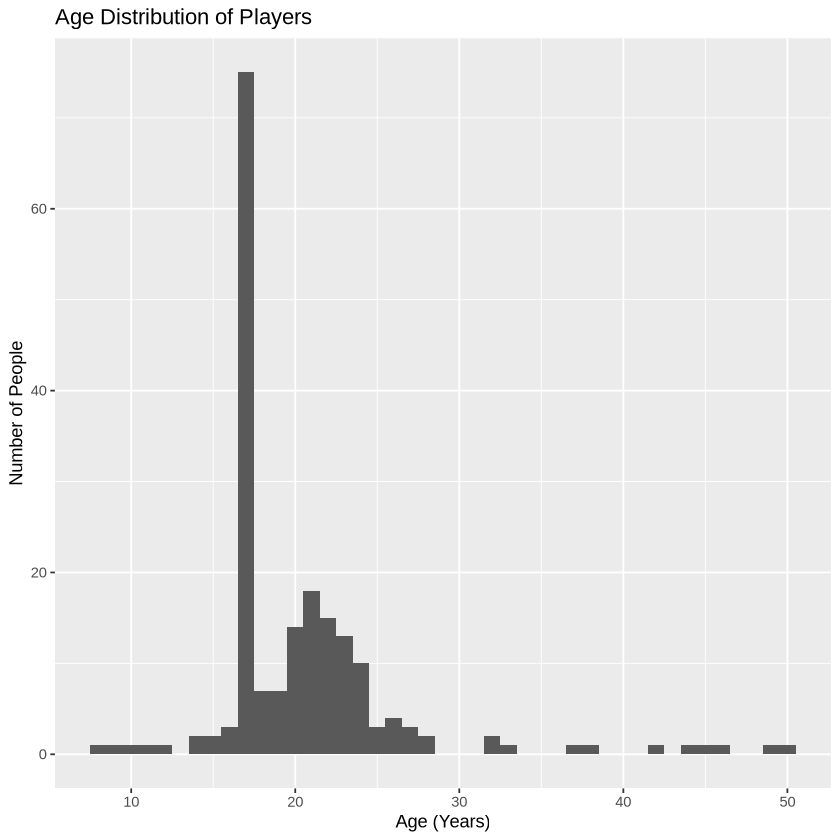

In [5]:
sample_stats <- players |>
    #calculating the mean, median, and standard deviation with summarize
    summarize(sample_mean = mean(age, na.rm = TRUE), sample_med = median(age, na.rm = TRUE), sample_sd = sd(age, na.rm = TRUE))
sample_stats

sample_distribution <- ggplot(players, aes(x = age)) + 
   geom_histogram(binwidth = 1) +
   labs(x = "Age (Years)", y = "Number of People") +
   ggtitle("Age Distribution of Players")
sample_distribution

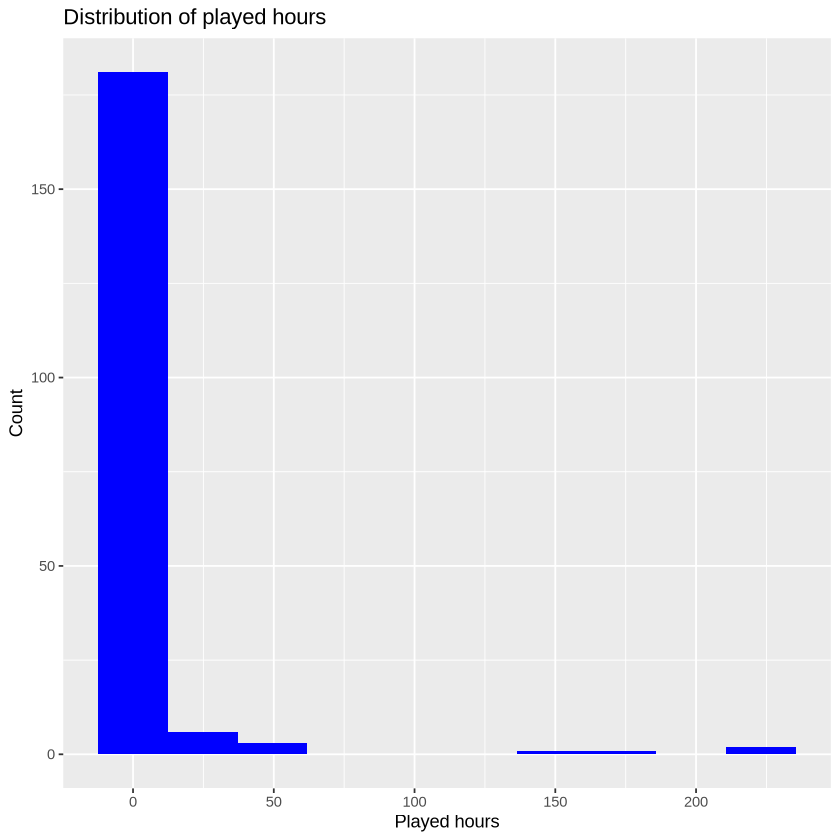

In [6]:
hours_distribution<-ggplot(players,aes(x = played_hours))+
geom_histogram(bins = 10,fill = "blue")+
labs(x = "Played hours", y = "Count")+
ggtitle("Distribution of played hours")
hours_distribution

In [7]:
subscribed_players <- players |>
    filter(subscribe == TRUE) |>
    nrow()
nonsubscribed_players <- players |>
    filter(subscribe == FALSE) |>
    nrow()
print(paste0(subscribed_players, " players out of 196 are subscribed, aka ", subscribed_players/196*100, " percent."))


[1] "142 players out of 196 are subscribed, aka 72.4489795918367 percent."


**(3)**
Above, we loaded and wrangled the dataset. The data appears tidy (one observation per row, value per cell, and variable per column).

The table of mean values is below:

In [8]:
#It was a fairly simple process to get a table of the numeric variable's mean values, as I applied the process learned in class
mean_table <- players |>
    select(played_hours,age) |>
    map_df(mean, na.rm = TRUE)
# noticed that there's at least one NA value in Age (???) so I had to remove them
mean_table

played_hours,age
<dbl>,<dbl>
5.904639,20.52062


The subscription percentages appear to be quite similar. This may not be a good predictor (or be problematic to analyze). However, prior to further predictive analysis this is unproven.

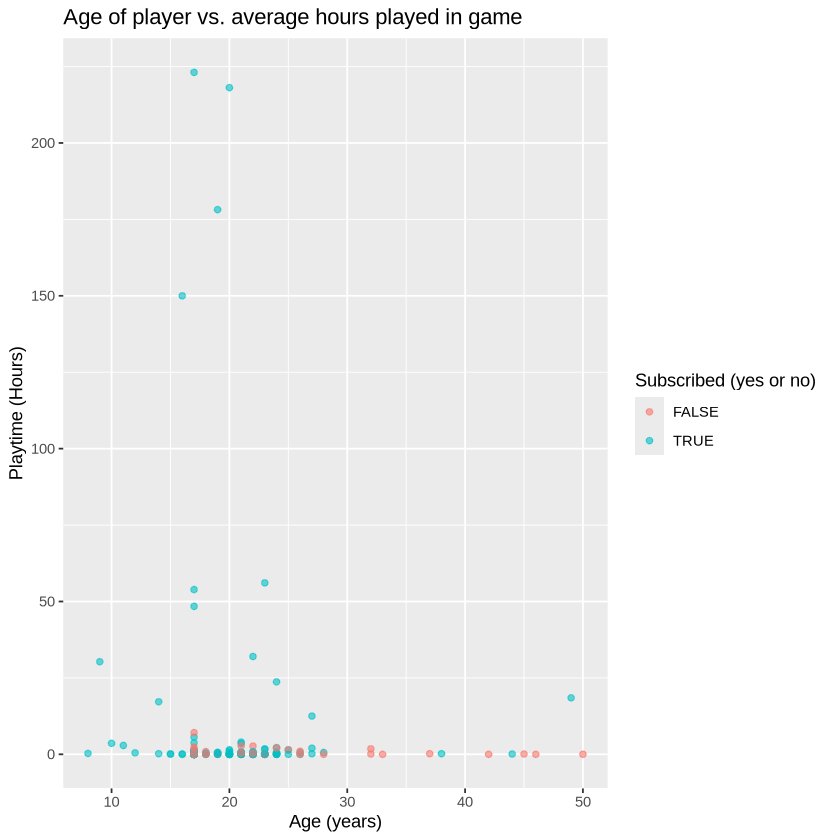

In [9]:
#For this visualization, I plan to plot age against playtime, with colour denoting subscription status (similar to the cancer classification example from class)
playtime_age_plot <- players |>
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (years)", y = "Playtime (Hours)", color = "Subscribed (yes or no)", title = "Age of player vs. average hours played in game")

playtime_age_plot

It appears most players have playtimes below 10 hours, and anyone above that is subscribed, which is intriguing. Additionally, higher playtimes are more common among younger people (age > 30), emphasizing the importance of scaling and centering the data.

Warning message:
“Removed 15 rows containing missing values or values outside the scale range
(`geom_point()`).”


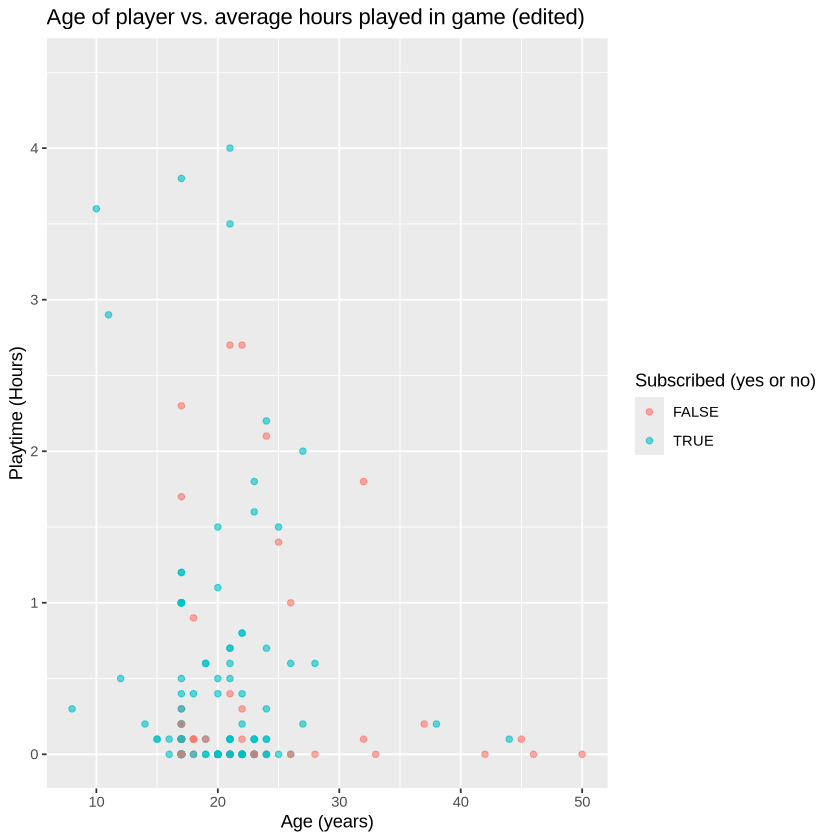

In [10]:
#cut out extreme outliers to provide better visual of data points
playtime_age_plot_better_visual <- playtime_age_plot +
    ylim(0, 4.5) +
    labs(title = "Age of player vs. average hours played in game (edited)")
playtime_age_plot_better_visual


We will now analyze whether age and played hours are good predictors of subscription status. To do this, we will split the data with 75% going to training and 25% going to testing, with the strata being the subscription status.

In [11]:
players_split <- initial_split(players, prop = 0.75, strata = subscribe)  
players_train <- training(players_split)   
players_test <- testing(players_split)

Made a recipe for predicting subscribe based on age and played hours.

In [12]:
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 


Made the model specification, a knn model for classification.

In [13]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

Made the workflow for tuning the model, collected the metrics, and found the best value of k.

In [14]:
players_vfold <- players_train |>
    vfold_cv(v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 112, by = 1))

knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics()
knn_results



→ A | warning: 112 samples were requested but there were 115 rows in the data. 110 will be used.

There were issues with some computations   A: x1

→ B | warning: 112 samples were requested but there were 116 rows in the data. 111 will be used.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x2

There were issues with some computations   A: x1   B: x3

There were issues with some computations   A: x1   B: x3





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4834483,5,0.02671913,Preprocessor1_Model001
1,roc_auc,binary,0.5401515,5,0.02760080,Preprocessor1_Model001
2,accuracy,binary,0.5036782,5,0.01468568,Preprocessor1_Model002
2,roc_auc,binary,0.5606911,5,0.03093328,Preprocessor1_Model002
3,accuracy,binary,0.5388834,5,0.03810382,Preprocessor1_Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
110,roc_auc,binary,0.6202188,5,0.017866556,Preprocessor1_Model110
111,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model111
111,roc_auc,binary,0.6294875,5,0.022665496,Preprocessor1_Model111


Now we will get the best k value in terms of accuracy. This can also be plotted as a visualization.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.7447126,5,0.008803427,Preprocessor1_Model021


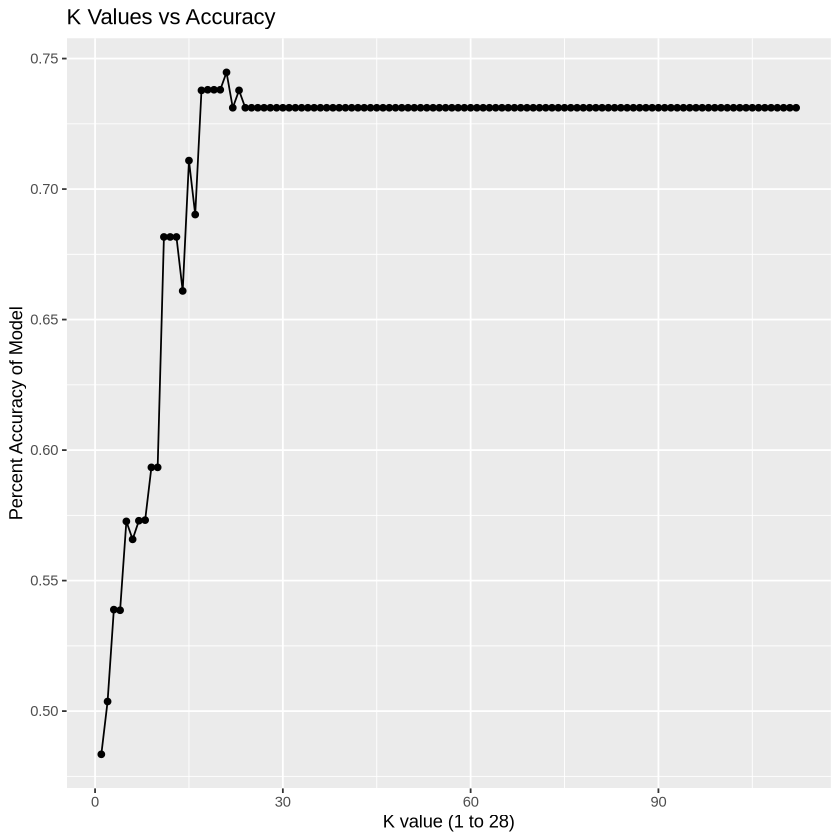

In [15]:
best_k <- knn_results |>
    filter(.metric == "accuracy") |>
    slice_max(order_by = mean, n = 1)
best_k

best_k_plot <- knn_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K value (1 to 28)", y = "Percent Accuracy of Model", title = "K Values vs Accuracy")
best_k_plot

From this data, the best k value appears to be k = 20

In [16]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |>
      set_engine("kknn") |>
      set_mode("classification")

In [17]:
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    fit(data = players_train)

Now we need to get the accuracy of the model on the testing set.

In [18]:
model_accuracy <- predict(players_fit, players_test) |>
    bind_cols(players_test) |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    head(1) |>
    pull()
model_accuracy

[1] 0.755102

Our accuracy with the model trained on age, is 75.5%. This is greater than 55%, thus age and played hours are a good predictor of subscription status.

**DISCUSSION**

The scatter plot shows the relationship between player age and playtime, distinguishing between subscribed and unsubscribed users. The majority of players seem to be under 30 years old, with a playtime of under 10 hours. A few outliers, which we cut out in the second graph for better visualization of the other points, were seen with over 150 hours of play time, and a few above 25 hours, all below 30 years of age. Because of this, we can observe that the general trend indicates that younger players tend to have higher playtime, particularly between the ages of 10 and 30 years. Subscription status also appears to be more common among younger players with there being a larger cluster amongst those who have lower playtime. After accounting for outliers and extreme values, it would be fair to conclude that players are more likely to be subscribed if they are younger and have a lower amount of playtime hours. However, this correlation is quite weak, as the points frequently overlap and are relatively spread out throughout the graph. 

This aligns with expectations, since younger players likely have more free time for gaming. Those who play less could also mean they are just starting to cultivate an interest in the game, and would be more inclined to subscribe due to their lack of experience. As for the outliers, the extremely high play times may suggest a more dedicated and experienced player, who, as seen in the data, would be subscribed due to their high engagement. 

With the knowledge of this trend, game developers can appropriately tailor subscription models and marketing strategies to target younger players to further capitalize on their current demographic or potentially find ways to address the older demographic and convince them to subscribe. 

A good question to ponder for the future would be whether other variables like experience could affect the subscription status as it is possible that the outliers might be veteran players who have high engagement with the game. Similarly, we theorized that since the bulk of subscriptions come from younger players with low playtime that they might be Beginner players, therefore it would be interesting to see whether these theories would be right and whether they have an actual impact. To improve, the study can also aim to increase its sample size and recruit more players to answer the survey, as it would account for greater variability and allow for a more accurate trend to be observed. 

Last but not least, our accuracy of the final model is about 75.5% when the neighbour is equal to 20, which is greater than 55% which shows it is a good predictor. These results align with general expectations for k-NN models. When k is small, the model tends to be more sensitive to noise and may overfit the training data. As k increases, the model becomes more generalized by considering more neighbors, leading to better performance up to a point. The observed plateau around k = 20 to k = 21 reflects the typical behavior of k-NN. Thus, this finding is consistent with theoretical expectations and demonstrates a good example of model tuning in action.

Since, selecting the appropriate k value is crucial for optimizing model performance, the fact that accuracy improves significantly with the chosen k value suggests that model tuning should never be overlooked. In real-world applications, a 10-20% improvement in accuracy can significantly influence outcomes.

Furthermore, understanding the plateau behavior helps prevent unnecessary computational expense—there’s little to gain from using extremely high k values once optimal performance has been reached. In large datasets, higher k values increase computational load, so identifying the optimal range ensures better efficiency.

Overall, this investigation explored the extent to which two key factors in player age and hours played can predict whether a player has subscribed to a game-related newsletter.

Our analysis suggests that both age and hours played have meaningful, though not exhaustive, relationships with subscription behavior. Younger players and those who are relatively new on the server are more likely to subscribe to the newsletter, indicating that active engagement and demographic factors play a role in a player’s willingness to stay connected with the game's ecosystem. Conversely, older players with low playing time show lower subscription rates, possibly reflecting either a more casual approach to gaming or differing interests in supplemental content.

However, while the predictive power of these two features is useful, it is also limited. Player behavior is shaped by a wide range of social, motivational, and contextual factors, many of which go beyond simple quantitative metrics like age and playtime. To build more developed predictive models in the future, it would be beneficial to include additional behavioral data, such as variables like experience and gender. This may yield deeper insights into why some players engage more deeply with a game's community than others.

From a practical perspective, these findings offer actionable insights for the UBC research group. Understanding the characteristics of likely subscribers can help inform how and when to prompt players to sign up for the newsletter.

Ultimately, this project illustrates the potential of data science to bridge gameplay behavior with real-world decisions and thereby contributing to both the success of research projects and the richness of the player experience and engagement.
